In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

/Users/soeren.becker/micromamba/envs/env_sc/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/soeren.becker/micromamba/envs/env_sc/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/soeren.becker/micromamba/envs/env_sc/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/soeren.becker/micromamba/envs/env_sc/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/soeren.becker/micromamba/envs/env_sc/lib/python3.12/site-packag

In [3]:
def _dict_to_dataframe(result_dict: dict, no_subgroups: bool = False):
    all_df = []
    for eval_category in ['ood_metrics_encoded', 'ood_metrics_decoded', 'deg_ood_metrics']:
        if "test" in eval_category:
            continue
        if "dict" in eval_category:
            continue
        if "target" in eval_category:
            continue
        df_id2 = pd.DataFrame()
        if no_subgroups:
            for condition in result_dict[eval_category].keys():
                row_idx = df_id2.shape[0]
                df_id2.loc[row_idx, "subgroup"] = "no_subgroup"
                df_id2.loc[row_idx, "condition"] = condition
                for metric in result_dict[eval_category][condition].keys():    
                    df_id2.loc[row_idx, eval_category+"_"+metric] = result_dict[eval_category][condition][metric]    
            
        else:
            for subgroup in result_dict[eval_category].keys():
                if subgroup == "all": 
                    continue
                for condition in result_dict[eval_category][subgroup].keys():
                    row_idx = df_id2.shape[0]
                    df_id2.loc[row_idx, "subgroup"] = subgroup
                    df_id2.loc[row_idx, "condition"] = condition
                    for metric in result_dict[eval_category][subgroup][condition].keys():    
                        df_id2.loc[row_idx, eval_category+"_"+metric] = result_dict[eval_category][subgroup][condition][metric]    
        all_df.append(df_id2)
    return pd.merge(pd.merge(all_df[0], all_df[1]), all_df[2])


def read_results_biolord(path: str):
    all_results = []
    for split in range(0, 5):
        result_dict = pd.read_pickle(os.path.join(path, f"biolord_split_{split}_collected_results.pkl"))
        results = _dict_to_dataframe(result_dict, no_subgroups=True)
        results.loc[:, "seed"] = split + 1
        all_results.append(results)
        
    df = pd.concat(all_results, axis=0).reset_index(drop=True)
    df.loc[:, "model"] = "biolord"
    return df


def read_results_cellflow(path: str, splits: list | None = None):
    if splits is None:
        splits = range(0, 5)
    if isinstance(splits, int):
        splits = [splits]
    all_results = []
    for split in splits:
        _path = glob.glob(os.path.join(path, f"cellflow_split_{split}_collected_results*.pkl"))
        assert len(_path) == 1
        _path = _path[0]
        result_dict = pd.read_pickle(_path)
        results = _dict_to_dataframe(result_dict)
        results.loc[:, "seed"] = split + 1
        all_results.append(results)
        
    df = pd.concat(all_results, axis=0).reset_index(drop=True)
    df.loc[:, "model"] = "cellflow"
    return df

def read_results_gears(path_gears):
    all_results = []
    for seed in range(1, 6):
        results_gears_single = pd.read_csv(os.path.join(path_gears, f"metrics_gearsoptimal_seed{seed}_unseensingle.csv"))
        results_gears_seen_0 = pd.read_csv(os.path.join(path_gears, f"metrics_gearsoptimal_seed{seed}_comboseen0.csv"))
        results_gears_seen_1 = pd.read_csv(os.path.join(path_gears, f"metrics_gearsoptimal_seed{seed}_comboseen1.csv"))
        results_gears_seen_2 = pd.read_csv(os.path.join(path_gears, f"metrics_gearsoptimal_seed{seed}_comboseen2.csv"))
        results_gears_single.loc[:, "subgroup"] = "single"
        results_gears_seen_0.loc[:, "subgroup"] = "double_seen_0"
        results_gears_seen_1.loc[:, "subgroup"] = "double_seen_1"
        results_gears_seen_2.loc[:, "subgroup"] = "double_seen_2"
        
        results_gears = pd.concat(
            [
                results_gears_single, 
                results_gears_seen_0, 
                results_gears_seen_1, 
                results_gears_seen_2
            ]
        )
        results_gears.loc[:, "seed"] = seed
        all_results.append(results_gears)
    
    df = pd.concat(all_results, axis=0)
    df.loc[:, "model"] = "gears"
    df = df.rename({"Unnamed: 0": "condition"}, axis=1).reset_index(drop=True)
    return df


def read_results_identity(path_gears):
    all_results = []
    for seed in range(1, 6):
        results_gears_single = pd.read_csv(os.path.join(path_gears, f"metrics_identity_seed{seed}_unseensingle.csv"))
        results_gears_seen_0 = pd.read_csv(os.path.join(path_gears, f"metrics_identity_seed{seed}_comboseen0.csv"))
        results_gears_seen_1 = pd.read_csv(os.path.join(path_gears, f"metrics_identity_seed{seed}_comboseen1.csv"))
        results_gears_seen_2 = pd.read_csv(os.path.join(path_gears, f"metrics_identity_seed{seed}_comboseen2.csv"))
        results_gears_single.loc[:, "subgroup"] = "single"
        results_gears_seen_0.loc[:, "subgroup"] = "double_seen_0"
        results_gears_seen_1.loc[:, "subgroup"] = "double_seen_1"
        results_gears_seen_2.loc[:, "subgroup"] = "double_seen_2"
        
        results_gears = pd.concat(
            [
                results_gears_single, 
                results_gears_seen_0, 
                results_gears_seen_1, 
                results_gears_seen_2
            ]
        )
        results_gears.loc[:, "seed"] = seed
        all_results.append(results_gears)
    
    df = pd.concat(all_results, axis=0)
    df.loc[:, "model"] = "identity"
    df = df.rename({"Unnamed: 0": "condition"}, axis=1).reset_index(drop=True)
    return df


def read_results_additive_model(path: str, splits: list | None = None):
    if splits is None:
        splits = range(0, 5)
    if isinstance(splits, int):
        splits = [splits]
    all_results = []
    for split in splits:
        _path = glob.glob(os.path.join(path, f"norman_additive_split_{split}_collected_results*.pkl"))
        assert len(_path) == 1
        _path = _path[0]
        result_dict = pd.read_pickle(_path)
        results = _dict_to_dataframe(result_dict, no_subgroups=True)
        results.loc[:, "seed"] = split + 1
        all_results.append(results)
        
    df = pd.concat(all_results, axis=0).reset_index(drop=True)
    df.loc[:, "model"] = "additive"
    return df

In [7]:
# read in results for all models
df_additive = read_results_additive_model("/Users/soeren.becker/repos/results_eval/additive_mean_displacement/num_samples_500")
df_biolord = read_results_biolord("/Users/soeren.becker/repos/results_eval/biolord_debug")
df_identity = read_results_identity("/Users/soeren.becker/repos/results_eval/gears")
df_gears = read_results_gears("/Users/soeren.becker/repos/results_eval/gears")
df_cellflow = read_results_cellflow("/Users/soeren.becker/repos/results_eval/cellflow/spring_sky_135")

In [8]:
# unify names of metrics
unified_names = {}
for m in np.unique(df_biolord.columns.tolist() + df_cellflow.columns.tolist()):
    unified_names[m] = m.replace("metrics_", "").replace("ood_decoded", "decoded_ood").replace("mmd_distance", "mmd").replace("ood_encoded", "encoded_ood")
df_cellflow.rename(unified_names, axis=1, inplace=True)
df_biolord.rename(unified_names, axis=1, inplace=True)
df_additive.rename(unified_names, axis=1, inplace=True)

In [9]:
# combine all results
df_all = pd.concat(
    [
        df_biolord, 
        df_gears, 
        df_identity, 
        df_cellflow,
        df_additive,
    ]
).reset_index(drop=True)
df_all = df_all.loc[df_all.condition != "mean"]
df_all

,subgroup,condition,encoded_ood_r_squared,encoded_ood_sinkhorn_div_1,encoded_ood_sinkhorn_div_10,encoded_ood_sinkhorn_div_100,encoded_ood_e_distance,encoded_ood_mmd,decoded_ood_r_squared,decoded_ood_e_distance,...,deg_ood_sinkhorn_div_1,deg_ood_sinkhorn_div_10,deg_ood_sinkhorn_div_100,deg_ood_e_distance,deg_ood_mmd,seed,model,decoded_ood_sinkhorn_div_1,decoded_ood_sinkhorn_div_10,decoded_ood_sinkhorn_div_100
0,no_subgroup,AHR+KLF1,-0.235969,26.363504,20.453796,13.004532,23.576266,0.088512,0.965454,59.965783,...,49.004730,23.053215,9.580486,18.465538,0.055382,1,biolord,NaN,NaN,NaN
1,no_subgroup,ARID1A+ctrl,-0.870820,32.711014,26.043972,15.835747,26.292580,0.075837,0.957185,65.454483,...,51.148735,24.314388,9.643890,18.312755,0.052491,1,biolord,NaN,NaN,NaN
2,no_subgroup,BCL2L11+BAK1,0.912641,8.554052,2.861893,0.661819,0.830657,0.019190,0.984661,25.525600,...,40.841179,14.373302,0.673000,0.470072,0.452304,1,biolord,NaN,NaN,NaN
3,no_subgroup,BCL2L11+TGFBR2,0.863316,9.772830,4.568264,0.941708,1.115361,0.019349,0.985263,24.123491,...,38.525169,14.326378,1.011749,1.303958,0.060637,1,biolord,NaN,NaN,NaN
4,no_subgroup,BCL2L11+ctrl,0.888504,9.687116,4.609301,0.755690,0.728787,0.016104,0.986481,22.218412,...,39.652954,13.896275,0.832378,0.833630,0.280454,1,biolord,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,no_subgroup,MAPK1+PRTG,-4.202307,14.472715,9.430771,6.527264,12.190199,0.036468,0.986057,22.730148,...,13.415939,1.778675,1.305035,2.558318,0.014213,5,additive,NaN,NaN,NaN
2344,no_subgroup,POU3F2+FOXL2,0.824329,21.481333,13.832615,4.632778,5.264625,0.029900,0.991699,13.639117,...,20.508587,4.773874,1.470818,2.503833,0.016490,5,additive,NaN,NaN,NaN
2345,no_subgroup,UBASH3B+OSR2,0.190902,9.449469,4.860416,2.849636,5.293981,0.018987,0.993751,10.390216,...,10.340317,1.293303,0.902847,1.774245,0.011690,5,additive,NaN,NaN,NaN
2346,no_subgroup,ZC3HAV1+HOXC13,-0.122444,14.419964,8.825829,3.224586,3.880091,0.024169,0.994298,9.115106,...,15.804873,2.182096,0.704794,1.237450,0.009411,5,additive,NaN,NaN,NaN


#### Sanity check: each random seed (= split) contains the same ood conditions for all models

In [10]:
for seed in df_all.seed.unique():
    a = df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition
    b = df_all.loc[(df_all.seed == seed) & (df_all.model == "biolord")].condition
    c = np.intersect1d(
        df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition,
        df_all.loc[(df_all.seed == seed) & (df_all.model == "biolord")].condition
    )
    assert len(a) == len(b) == len(c)
    
    a = df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition
    b = df_all.loc[(df_all.seed == seed) & (df_all.model == "cellflow")].condition
    c = np.intersect1d(
        df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition,
        df_all.loc[(df_all.seed == seed) & (df_all.model == "cellflow")].condition
    )
    assert len(a) == len(b) == len(c)
    
    a = df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition
    b = df_all.loc[(df_all.seed == seed) & (df_all.model == "identity")].condition
    c = np.intersect1d(
        df_all.loc[(df_all.seed == seed) & (df_all.model == "gears")].condition,
        df_all.loc[(df_all.seed == seed) & (df_all.model == "identity")].condition
    )
    assert len(a) == len(b) == len(c)
print("All assertions passed.")

All assertions passed.


In [11]:
meta_info_columns = ["seed", "subgroup", "model", "condition"]
metric_columns = [m for m in df_all.columns if not m in meta_info_columns]
#df_all = 
df_all[meta_info_columns+metric_columns]

,seed,subgroup,model,condition,encoded_ood_r_squared,encoded_ood_sinkhorn_div_1,encoded_ood_sinkhorn_div_10,encoded_ood_sinkhorn_div_100,encoded_ood_e_distance,encoded_ood_mmd,...,decoded_ood_mmd,deg_ood_r_squared,deg_ood_sinkhorn_div_1,deg_ood_sinkhorn_div_10,deg_ood_sinkhorn_div_100,deg_ood_e_distance,deg_ood_mmd,decoded_ood_sinkhorn_div_1,decoded_ood_sinkhorn_div_10,decoded_ood_sinkhorn_div_100
0,1,no_subgroup,biolord,AHR+KLF1,-0.235969,26.363504,20.453796,13.004532,23.576266,0.088512,...,0.045247,0.833845,49.004730,23.053215,9.580486,18.465538,0.055382,NaN,NaN,NaN
1,1,no_subgroup,biolord,ARID1A+ctrl,-0.870820,32.711014,26.043972,15.835747,26.292580,0.075837,...,0.025340,0.885729,51.148735,24.314388,9.643890,18.312755,0.052491,NaN,NaN,NaN
2,1,no_subgroup,biolord,BCL2L11+BAK1,0.912641,8.554052,2.861893,0.661819,0.830657,0.019190,...,0.055012,0.299255,40.841179,14.373302,0.673000,0.470072,0.452304,NaN,NaN,NaN
3,1,no_subgroup,biolord,BCL2L11+TGFBR2,0.863316,9.772830,4.568264,0.941708,1.115361,0.019349,...,0.050813,0.978135,38.525169,14.326378,1.011749,1.303958,0.060637,NaN,NaN,NaN
4,1,no_subgroup,biolord,BCL2L11+ctrl,0.888504,9.687116,4.609301,0.755690,0.728787,0.016104,...,0.048935,0.957883,39.652954,13.896275,0.832378,0.833630,0.280454,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,5,no_subgroup,additive,MAPK1+PRTG,-4.202307,14.472715,9.430771,6.527264,12.190199,0.036468,...,0.009732,0.964040,13.415939,1.778675,1.305035,2.558318,0.014213,NaN,NaN,NaN
2344,5,no_subgroup,additive,POU3F2+FOXL2,0.824329,21.481333,13.832615,4.632778,5.264625,0.029900,...,0.017002,0.985863,20.508587,4.773874,1.470818,2.503833,0.016490,NaN,NaN,NaN
2345,5,no_subgroup,additive,UBASH3B+OSR2,0.190902,9.449469,4.860416,2.849636,5.293981,0.018987,...,0.005137,0.983658,10.340317,1.293303,0.902847,1.774245,0.011690,NaN,NaN,NaN
2346,5,no_subgroup,additive,ZC3HAV1+HOXC13,-0.122444,14.419964,8.825829,3.224586,3.880091,0.024169,...,0.007034,0.992116,15.804873,2.182096,0.704794,1.237450,0.009411,NaN,NaN,NaN


#### unify condition-to-subgroup mapping: we use the original mapping from gears

In [12]:
seed_to_train_condition = {}

for split in range(5):
    adata = sc.read_h5ad(f"/Users/soeren.becker/repos/results_eval/data/adata_train_{split}.h5ad")
    seed = split + 1

    single_perturbed_genes = adata.obs.loc[
        adata.obs.condition.str.contains("+ctrl", regex=False) | 
        adata.obs.condition.str.contains("ctrl+", regex=False)
    ].condition.str.replace("+ctrl", "").str.replace("ctrl+", "")

    seed_to_train_condition[seed] = single_perturbed_genes.unique()

df_per_seed = []

for seed in range(1, 6):

    df_this_seed = df_all.loc[df_all.seed == seed]
    
    genes = df_this_seed.condition.str.split("+", expand=True)
    gene1_mask = genes.loc[:, 0].isin(seed_to_train_condition[seed])
    gene2_mask = genes.loc[:, 1].isin(seed_to_train_condition[seed])

    mask_single = df_this_seed.condition.str.contains("+ctrl", regex=False) | df_this_seed.condition.str.contains("ctrl+", regex=False)
    mask_double_seen_2 = (~mask_single) & (gene1_mask & gene2_mask)
    mask_double_seen_1 = (~mask_single) & ((gene1_mask & ~gene2_mask) | (gene2_mask & ~gene1_mask))
    mask_double_seen_0 = (~mask_single) & ((~gene1_mask) & (~gene2_mask))

    df_this_seed.loc[mask_double_seen_0, "subgroup"] = "double_seen_0"
    df_this_seed.loc[mask_double_seen_1, "subgroup"] = "double_seen_1"
    df_this_seed.loc[mask_double_seen_2, "subgroup"] = "double_seen_2"
    df_this_seed.loc[mask_single, "subgroup"] = "single"
    
    df_per_seed.append(df_this_seed)

df_all = pd.concat(df_per_seed, axis=0)

#### Sanity check: there should be 5 splits per subgroup for each model (except for the additive model which can only be applied to the double_seen_2 subgroup)

In [13]:
df_all.groupby(["model", "subgroup"]).seed.nunique()

model     subgroup     
additive  double_seen_2    5
biolord   double_seen_0    5
          double_seen_1    5
          double_seen_2    5
          single           5
cellflow  double_seen_0    5
          double_seen_1    5
          double_seen_2    5
          single           5
gears     double_seen_0    5
          double_seen_1    5
          double_seen_2    5
          single           5
identity  double_seen_0    5
          double_seen_1    5
          double_seen_2    5
          single           5
Name: seed, dtype: int64

#### Compute mean for each split x subgroup x model combination (The mean is across all conditions in that combination.)

In [14]:
df_means = (
    df_all.drop(columns=["condition"])  # Drop 'condition' column
    .groupby(["model", "seed", "subgroup"], as_index=False)
    .mean()  # Take the mean of the remaining columns
)
df_means

,model,seed,subgroup,encoded_ood_r_squared,encoded_ood_sinkhorn_div_1,encoded_ood_sinkhorn_div_10,encoded_ood_sinkhorn_div_100,encoded_ood_e_distance,encoded_ood_mmd,decoded_ood_r_squared,...,decoded_ood_mmd,deg_ood_r_squared,deg_ood_sinkhorn_div_1,deg_ood_sinkhorn_div_10,deg_ood_sinkhorn_div_100,deg_ood_e_distance,deg_ood_mmd,decoded_ood_sinkhorn_div_1,decoded_ood_sinkhorn_div_10,decoded_ood_sinkhorn_div_100
0,additive,1,double_seen_2,0.494123,20.856241,14.394173,6.274500,7.404721,0.033791,0.990563,...,0.012217,0.973641,17.404671,4.677067,1.897256,3.115837,0.020112,NaN,NaN,NaN
1,additive,2,double_seen_2,0.269308,17.529911,11.574005,5.940565,9.520363,0.031986,0.990249,...,0.009847,0.975930,13.746888,3.152803,1.608465,3.008569,0.018010,NaN,NaN,NaN
2,additive,3,double_seen_2,0.730247,34.811114,27.539011,13.634190,14.156316,0.052663,0.983596,...,0.021120,0.844307,17.964672,6.572182,2.908889,4.535062,0.044732,NaN,NaN,NaN
3,additive,4,double_seen_2,0.745474,20.484564,13.874123,5.179386,5.876316,0.029412,0.990875,...,0.012377,0.983004,13.230654,3.574622,1.477514,2.538742,0.020355,NaN,NaN,NaN
4,additive,5,double_seen_2,-0.087738,18.957889,12.623701,5.749296,7.823952,0.030240,0.990063,...,0.011410,0.977842,13.689848,3.271296,1.450525,2.536158,0.018802,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,identity,4,single,-0.914947,19.773949,14.158397,9.835557,18.284895,0.039571,0.981706,...,0.013445,0.856047,15.448985,8.062129,7.062432,13.978032,0.060825,308.358404,283.377070,40.259045
81,identity,5,double_seen_0,-0.968409,88.655958,80.879354,66.143409,117.471778,0.144372,0.916715,...,0.034123,0.498038,34.119225,24.067712,20.203898,39.034689,0.133412,462.895857,442.244612,168.161502
82,identity,5,double_seen_1,-0.915423,54.159585,47.502874,38.473719,70.278456,0.102985,0.947485,...,0.024802,-17.954906,32.797189,22.266601,19.706477,38.675481,0.111858,383.535975,360.334085,102.120542
83,identity,5,double_seen_2,-1.238905,41.108520,34.541990,27.413707,50.994410,0.078533,0.956733,...,0.021015,0.734526,28.804125,18.172433,16.285159,32.195092,0.089774,363.768313,339.810515,77.187080


In [15]:
df_all.loc[df_all.subgroup != "single"].condition.nunique()

128

In [16]:
with pd.option_context("display.max_rows", 500):
    display(df_all.loc[df_all.subgroup == "double_seen_2"].groupby(["seed", "condition"]).model.nunique())

seed  condition     
1     CEBPE+CNN1        5
      CNN1+MAPK1        5
      ETS2+CEBPE        5
      ETS2+CNN1         5
      ETS2+MAPK1        5
      FEV+ISL2          5
      FOSB+CEBPE        5
      FOXA1+HOXB9       5
      FOXA3+HOXB9       5
      MAP2K3+IKZF3      5
      POU3F2+CBFA2T3    5
      SNAI1+DLX2        5
      UBASH3B+PTPN12    5
      UBASH3B+ZBTB25    5
      ZC3HAV1+HOXC13    5
2     CDKN1B+CDKN1A     5
      CDKN1C+CDKN1A     5
      CEBPB+PTPN12      5
      CEBPE+RUNX1T1     5
      DUSP9+KLF1        5
      FEV+MAP7D1        5
      FOXA3+FOXF1       5
      KLF1+TGFBR2       5
      MAP2K6+ELMSAN1    5
      PTPN12+PTPN9      5
      SAMD1+PTPN12      5
      SAMD1+UBASH3B     5
      SET+CEBPE         5
      UBASH3B+PTPN9     5
      ZC3HAV1+HOXC13    5
3     CEBPB+OSR2        5
      CEBPE+RUNX1T1     5
      DUSP9+IGDCC3      5
      DUSP9+SNAI1       5
      FEV+ISL2          5
      FOXA3+FOXA1       5
      JUN+CEBPA         5
      JUN+CEBPB  

In [17]:
# some deg conditions have negative r2 results
df_all.loc[df_all.deg_ood_r_squared < 0, ["subgroup", "condition", "seed", "model", "deg_ood_r_squared"]].sort_values(["condition", "seed", "model"])

,subgroup,condition,seed,model,deg_ood_r_squared
6,double_seen_0,C3orf72+FOXL2,1,biolord,-4870.599121
1782,double_seen_0,C3orf72+FOXL2,1,cellflow,-1926.103271
599,double_seen_0,C3orf72+FOXL2,1,gears,-10204.254883
1180,double_seen_0,C3orf72+FOXL2,1,identity,-1024.455688
112,double_seen_0,C3orf72+FOXL2,2,biolord,-5710.741699
1896,double_seen_0,C3orf72+FOXL2,2,cellflow,-1562.882935
727,double_seen_0,C3orf72+FOXL2,2,gears,-20728.080078
1308,double_seen_0,C3orf72+FOXL2,2,identity,-1024.455688
340,double_seen_1,C3orf72+FOXL2,4,biolord,-3578.813965
2071,double_seen_1,C3orf72+FOXL2,4,cellflow,-2300.159424


In [18]:
SUBGROUP_ORDER = ["single", "double_seen_2", "double_seen_1", "double_seen_0"]
HUE_ORDER = ["cellflow", "gears", "biolord", "identity", "additive",]

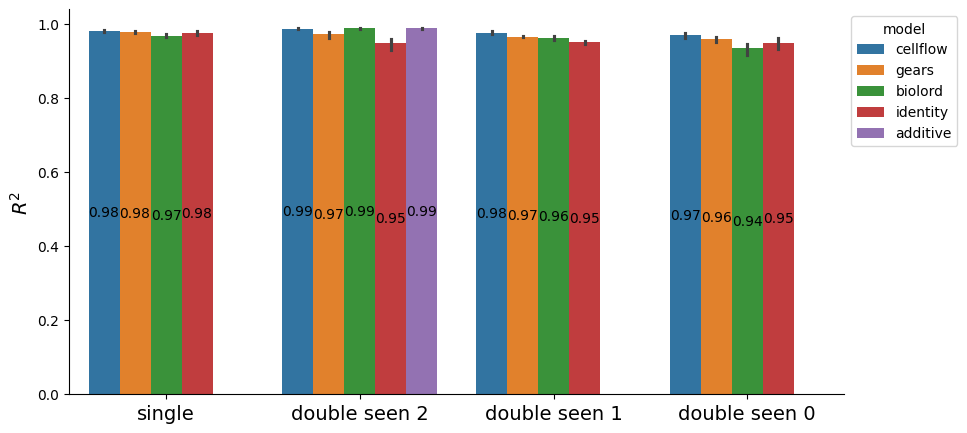

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.barplot(
    # df_all.loc[df_all.condition == "mean"],
    data = df_means,
    x = "subgroup",
    y = "decoded_ood_r_squared",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel(r"$R^2$", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

[ax.bar_label(ax.containers[k], fmt='%.2f', label_type='center') for k in range(len(ax.containers))]
plt.show()

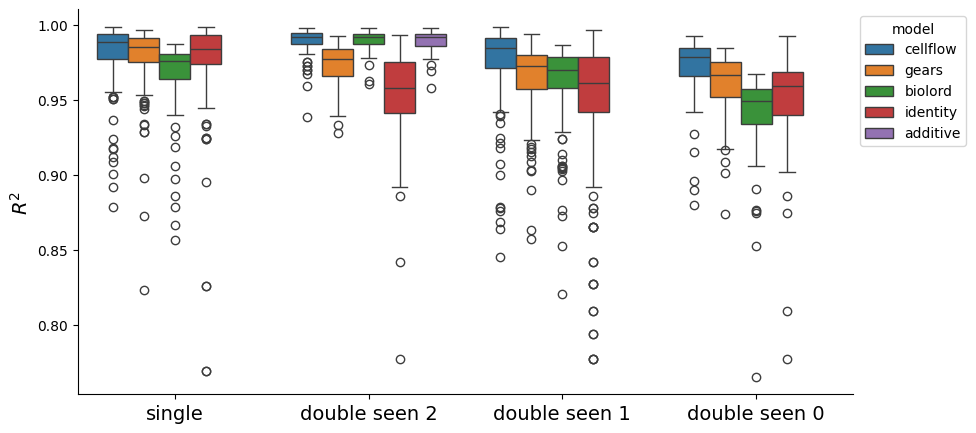

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "decoded_ood_r_squared",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel(r"$R^2$", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

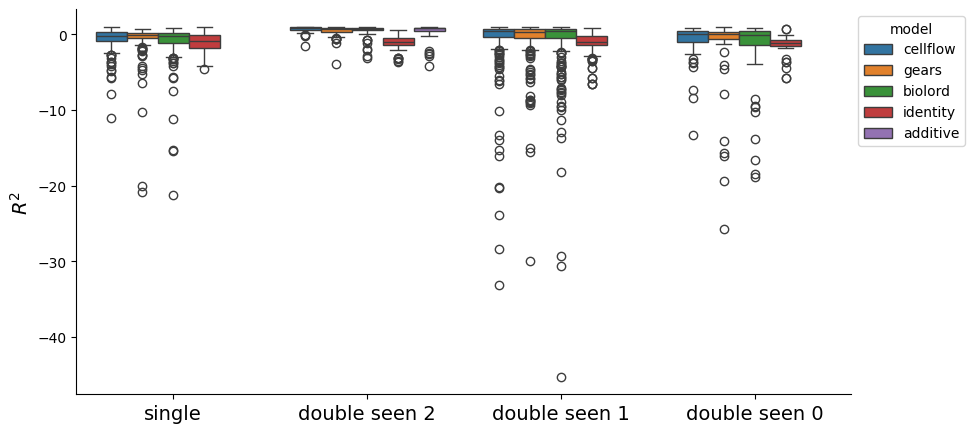

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "encoded_ood_r_squared",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel(r"$R^2$", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

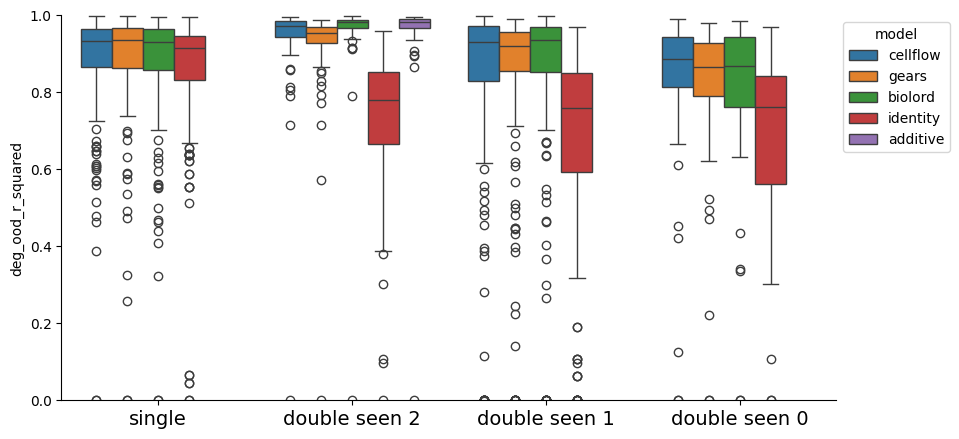

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "deg_ood_r_squared",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0, 1])
plt.show()

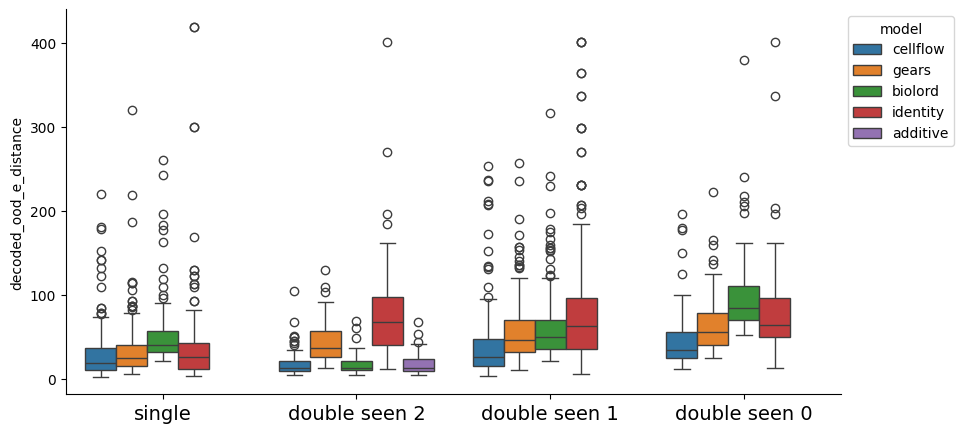

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "decoded_ood_e_distance",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

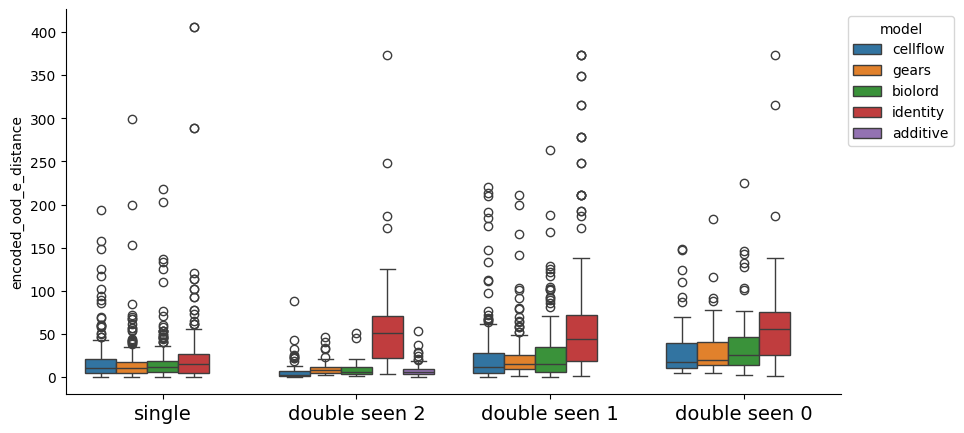

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "encoded_ood_e_distance",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

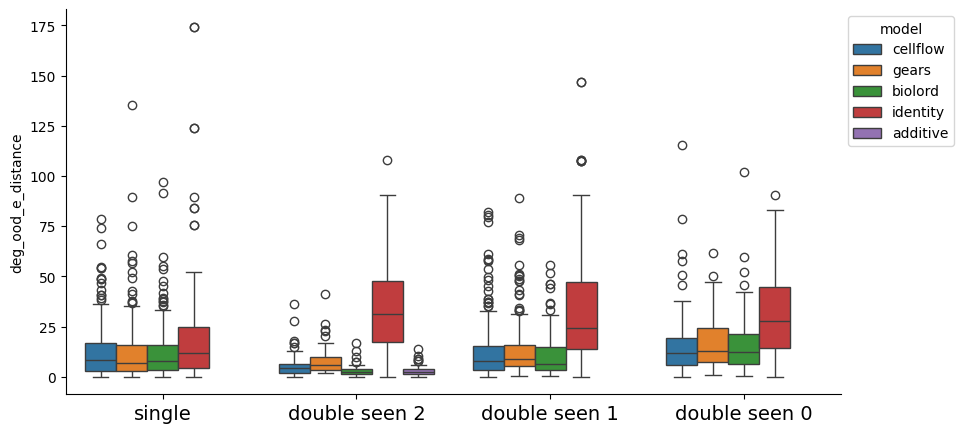

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "deg_ood_e_distance",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

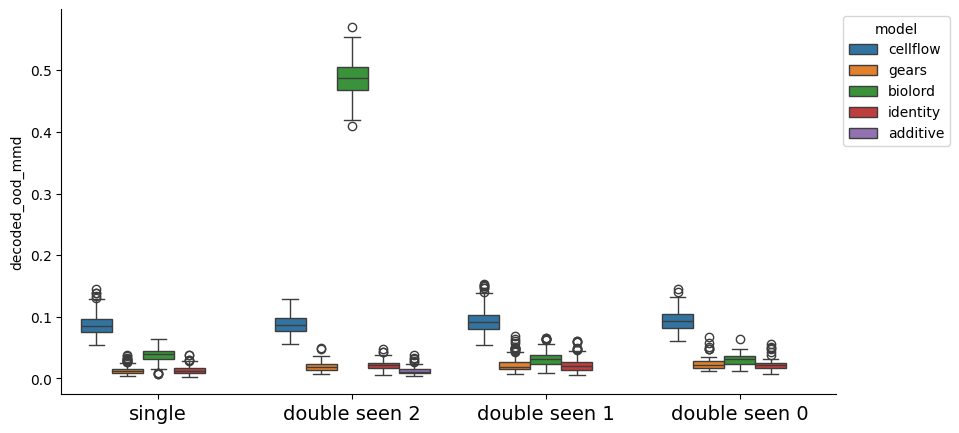

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "decoded_ood_mmd",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

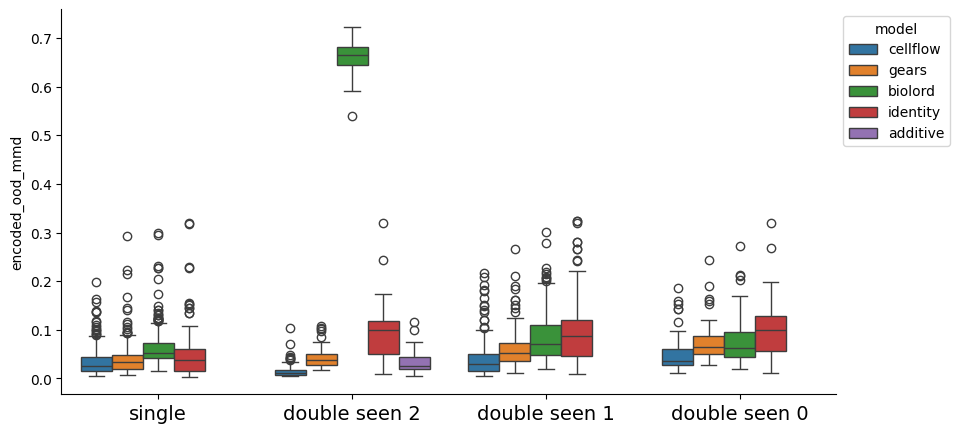

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "encoded_ood_mmd",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

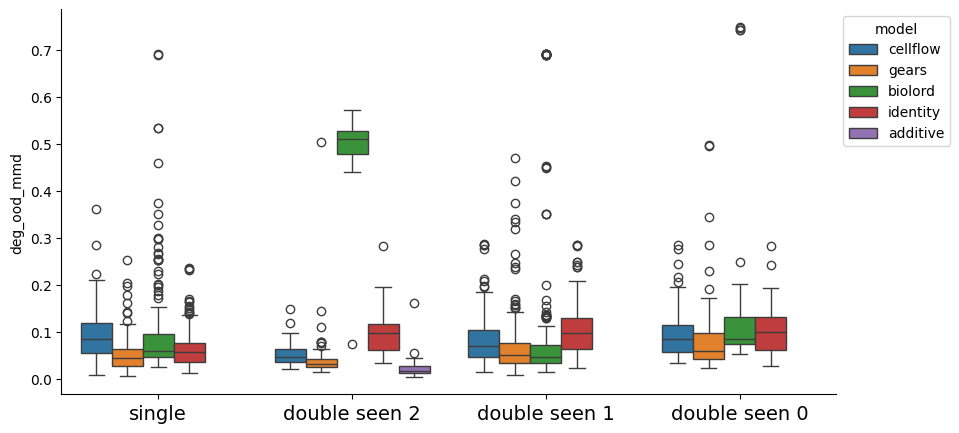

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "deg_ood_mmd",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

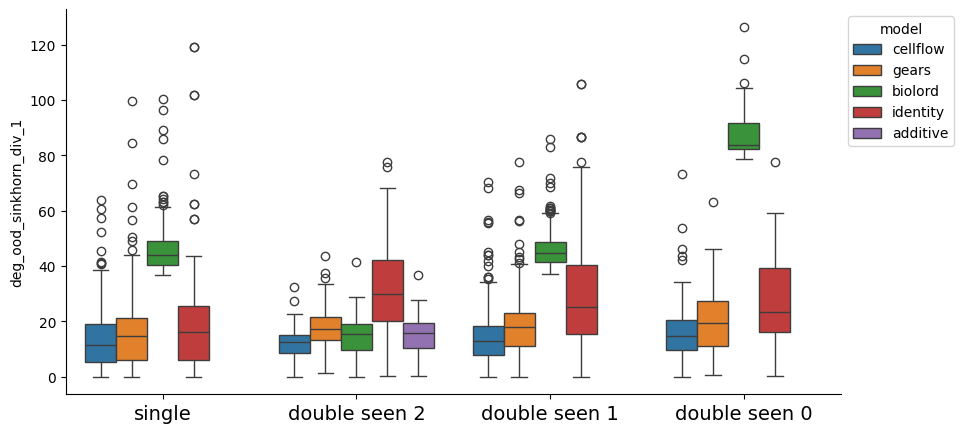

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "deg_ood_sinkhorn_div_1",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

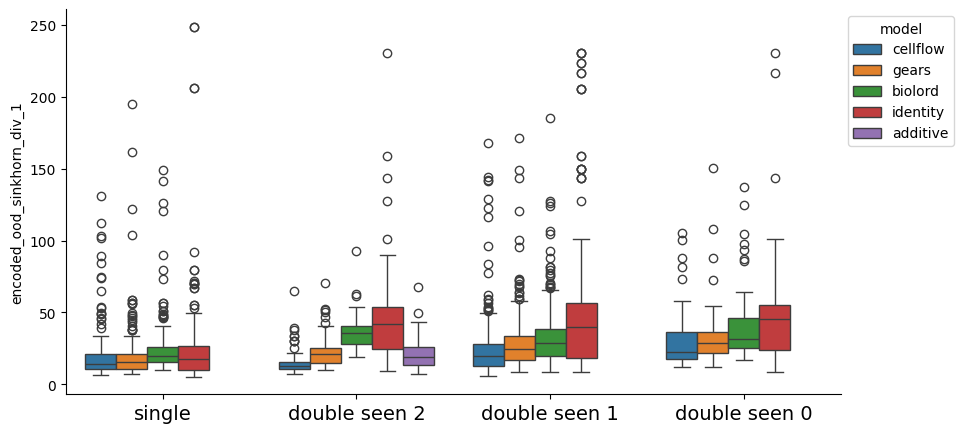

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax = sns.boxplot(
    df_all.loc[df_all.condition != "mean"],
    x = "subgroup",
    y = "encoded_ood_sinkhorn_div_1",
    hue="model",
    order=SUBGROUP_ORDER,
    hue_order=HUE_ORDER,
)
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["single", "double seen 2", "double seen 1", "double seen 0"], fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [31]:
df_all.columns

Index(['subgroup', 'condition', 'encoded_ood_r_squared',
       'encoded_ood_sinkhorn_div_1', 'encoded_ood_sinkhorn_div_10',
       'encoded_ood_sinkhorn_div_100', 'encoded_ood_e_distance',
       'encoded_ood_mmd', 'decoded_ood_r_squared', 'decoded_ood_e_distance',
       'decoded_ood_mmd', 'deg_ood_r_squared', 'deg_ood_sinkhorn_div_1',
       'deg_ood_sinkhorn_div_10', 'deg_ood_sinkhorn_div_100',
       'deg_ood_e_distance', 'deg_ood_mmd', 'seed', 'model',
       'decoded_ood_sinkhorn_div_1', 'decoded_ood_sinkhorn_div_10',
       'decoded_ood_sinkhorn_div_100'],
      dtype='object')

In [ ]:
df_all.to_csv("/Users/soeren.becker/repos/results_eval/results_norman_all.csv")

In [33]:
df_all

,subgroup,condition,encoded_ood_r_squared,encoded_ood_sinkhorn_div_1,encoded_ood_sinkhorn_div_10,encoded_ood_sinkhorn_div_100,encoded_ood_e_distance,encoded_ood_mmd,decoded_ood_r_squared,decoded_ood_e_distance,...,deg_ood_sinkhorn_div_1,deg_ood_sinkhorn_div_10,deg_ood_sinkhorn_div_100,deg_ood_e_distance,deg_ood_mmd,seed,model,decoded_ood_sinkhorn_div_1,decoded_ood_sinkhorn_div_10,decoded_ood_sinkhorn_div_100
0,double_seen_1,AHR+KLF1,-0.235969,26.363504,20.453796,13.004532,23.576266,0.088512,0.965454,59.965783,...,49.004730,23.053215,9.580486,18.465538,0.055382,1,biolord,NaN,NaN,NaN
1,single,ARID1A+ctrl,-0.870820,32.711014,26.043972,15.835747,26.292580,0.075837,0.957185,65.454483,...,51.148735,24.314388,9.643890,18.312755,0.052491,1,biolord,NaN,NaN,NaN
2,double_seen_1,BCL2L11+BAK1,0.912641,8.554052,2.861893,0.661819,0.830657,0.019190,0.984661,25.525600,...,40.841179,14.373302,0.673000,0.470072,0.452304,1,biolord,NaN,NaN,NaN
3,double_seen_1,BCL2L11+TGFBR2,0.863316,9.772830,4.568264,0.941708,1.115361,0.019349,0.985263,24.123491,...,38.525169,14.326378,1.011749,1.303958,0.060637,1,biolord,NaN,NaN,NaN
4,single,BCL2L11+ctrl,0.888504,9.687116,4.609301,0.755690,0.728787,0.016104,0.986481,22.218412,...,39.652954,13.896275,0.832378,0.833630,0.280454,1,biolord,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,double_seen_2,MAPK1+PRTG,-4.202307,14.472715,9.430771,6.527264,12.190199,0.036468,0.986057,22.730148,...,13.415939,1.778675,1.305035,2.558318,0.014213,5,additive,NaN,NaN,NaN
2344,double_seen_2,POU3F2+FOXL2,0.824329,21.481333,13.832615,4.632778,5.264625,0.029900,0.991699,13.639117,...,20.508587,4.773874,1.470818,2.503833,0.016490,5,additive,NaN,NaN,NaN
2345,double_seen_2,UBASH3B+OSR2,0.190902,9.449469,4.860416,2.849636,5.293981,0.018987,0.993751,10.390216,...,10.340317,1.293303,0.902847,1.774245,0.011690,5,additive,NaN,NaN,NaN
2346,double_seen_2,ZC3HAV1+HOXC13,-0.122444,14.419964,8.825829,3.224586,3.880091,0.024169,0.994298,9.115106,...,15.804873,2.182096,0.704794,1.237450,0.009411,5,additive,NaN,NaN,NaN


In [34]:
with pd.option_context("display.max_rows", 1000):
    display(df_all.groupby(["subgroup", "seed", "condition"]).model.nunique())

subgroup       seed  condition      
double_seen_0  1     C3orf72+FOXL2      4
                     CBL+PTPN9          4
                     CDKN1B+CDKN1A      4
                     CDKN1C+CDKN1A      4
                     CDKN1C+CDKN1B      4
                     CEBPB+OSR2         4
                     DUSP9+KLF1         4
                     DUSP9+PRTG         4
                     FOXL2+MEIS1        4
                     JUN+CEBPB          4
                     KLF1+COL2A1        4
                     ZBTB10+ELMSAN1     4
               2     C3orf72+FOXL2      4
                     CNN1+MAPK1         4
                     CNN1+UBASH3A       4
                     ETS2+CNN1          4
                     ETS2+IKZF3         4
                     ETS2+MAPK1         4
                     ETS2+PRTG          4
                     FOSB+IKZF3         4
                     FOXA1+FOXL2        4
                     JUN+CEBPA          4
                     MAP2K3+IKZF3      

In [35]:
with pd.option_context("display.max_rows", 100):
    display(df_all.loc[df_all.deg_ood_r_squared == 0, ["subgroup", "seed", "condition", "model", "deg_ood_r_squared"]].sort_values(["seed", "condition"]))

,subgroup,seed,condition,model,deg_ood_r_squared
12,double_seen_1,1,CBL+UBASH3A,biolord,0.0
614,double_seen_1,1,CBL+UBASH3A,gears,0.0
1195,double_seen_1,1,CBL+UBASH3A,identity,0.0
1744,double_seen_1,1,CBL+UBASH3A,cellflow,0.0
60,double_seen_0,1,JUN+CEBPB,biolord,0.0
607,double_seen_0,1,JUN+CEBPB,gears,0.0
1188,double_seen_0,1,JUN+CEBPB,identity,0.0
1791,double_seen_0,1,JUN+CEBPB,cellflow,0.0
114,double_seen_1,2,CBL+UBASH3A,biolord,0.0
729,double_seen_1,2,CBL+UBASH3A,gears,0.0


In [36]:
df_all.loc[df_all.deg_ood_r_squared == 0].condition.unique()

array(['CBL+UBASH3A', 'JUN+CEBPB', 'KIF18B+KIF2C', 'PLK4+STIL',
       'PLK4+ctrl'], dtype=object)

In [37]:
with pd.option_context("display.max_rows", 100):
    display(df_all.loc[df_all.deg_ood_r_squared == 0, ["subgroup", "seed", "condition", "model", "deg_ood_r_squared"]].sort_values(["seed", "condition"]))

,subgroup,seed,condition,model,deg_ood_r_squared
12,double_seen_1,1,CBL+UBASH3A,biolord,0.0
614,double_seen_1,1,CBL+UBASH3A,gears,0.0
1195,double_seen_1,1,CBL+UBASH3A,identity,0.0
1744,double_seen_1,1,CBL+UBASH3A,cellflow,0.0
60,double_seen_0,1,JUN+CEBPB,biolord,0.0
607,double_seen_0,1,JUN+CEBPB,gears,0.0
1188,double_seen_0,1,JUN+CEBPB,identity,0.0
1791,double_seen_0,1,JUN+CEBPB,cellflow,0.0
114,double_seen_1,2,CBL+UBASH3A,biolord,0.0
729,double_seen_1,2,CBL+UBASH3A,gears,0.0


In [39]:
df_all.loc[df_all.deg_ood_r_squared == 0, ["subgroup", "seed", "condition", "model", "deg_ood_r_squared"]]\
    .groupby(["subgroup", "seed", "condition"]).model.nunique()\
    .to_frame()\
    .reset_index()\
    .rename({"model": "num models"}, axis=1)\
    .sort_values(["subgroup", "seed", "condition"])                                                                                                                                                                                       

,subgroup,seed,condition,num models
0,double_seen_0,1,JUN+CEBPB,4
1,double_seen_0,5,CBL+UBASH3A,4
2,double_seen_1,1,CBL+UBASH3A,4
3,double_seen_1,2,CBL+UBASH3A,4
4,double_seen_1,2,KIF18B+KIF2C,4
5,double_seen_1,3,KIF18B+KIF2C,4
6,double_seen_1,3,PLK4+STIL,4
7,double_seen_1,4,CBL+UBASH3A,4
8,double_seen_1,4,JUN+CEBPB,4
9,double_seen_1,4,KIF18B+KIF2C,4
